In [561]:
## PACKAGES


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import umap.umap_ as umap
import torch
import torchvision.transforms as transforms
import timm
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

from IPython.display import display, clear_output
import sys
sys.path.insert(1,'/home/shelia/AllFiles/Research_tuly/pyDeepInsight/pyDeepInsight_SRT/')
from pyDeepInsight import ImageTransformer, CAMFeatureSelector

In [566]:
##LOAD DATA
expr_file = r"../data/Survival_TCGA_VS_Desmd/filtered_desmd_average_ver1.csv"
expr1 = pd.read_csv(expr_file, encoding='utf-8', engine='python')
expr=expr1.transpose()
expr.columns=expr.iloc[0]
X_all = expr.iloc[1:,1:-1].values
X_all=X_all.astype(float)
days= expr.iloc[1:,-1].values
genes = expr.iloc[:,:-1].columns.to_numpy()


In [572]:
X_all.shape

(198, 12586)

In [577]:
X=np.zeros((160,12586))
Y=[]
check=[]
j=0
for i in range(198):
    if days[i]<=1500:
        X[j]=X[j]+X_all[i]
        Y.append('short')
        check.append(days[i])
        j=j+1
    if days[i]>=3000:
        X[j]=X[j]+X_all[i]
        Y.append('long')
        check.append(days[i])
        j=j+1
    

In [581]:
Y=np.array(Y)
Y

array(['short', 'short', 'short', 'long', 'long', 'short', 'long', 'long',
       'short', 'short', 'long', 'long', 'short', 'short', 'short',
       'short', 'long', 'long', 'long', 'long', 'short', 'long', 'long',
       'short', 'long', 'long', 'long', 'long', 'short', 'long', 'short',
       'long', 'short', 'long', 'long', 'long', 'short', 'short', 'long',
       'short', 'long', 'short', 'long', 'long', 'long', 'short', 'short',
       'long', 'short', 'long', 'long', 'long', 'short', 'long', 'short',
       'long', 'long', 'long', 'long', 'long', 'short', 'short', 'long',
       'long', 'short', 'long', 'long', 'long', 'long', 'long', 'long',
       'long', 'long', 'long', 'short', 'long', 'long', 'long', 'long',
       'long', 'short', 'short', 'short', 'long', 'long', 'long', 'short',
       'short', 'short', 'long', 'long', 'long', 'short', 'short', 'long',
       'long', 'long', 'long', 'long', 'short', 'long', 'long', 'long',
       'long', 'long', 'short', 'long', 'long', 

In [582]:
random_state=1515
X_train, X_test, y_train, y_test = train_test_split(
X, Y, test_size=0.2, shuffle=True, stratify=Y)

In [583]:
X_train[0].shape

(12586,)

In [ ]:
chosen_samples=X_train[y_train=='long']
chosen_samples2=X_train[y_train=='short']
chosen_indices=np.random.choice(chosen_samples.shape[0], size=50, replace=False)
chosen_samples=chosen_samples[chosen_indices]
X_train_modified=np.zeros((100,12586))
y_train_modified=np.empty((100),dtype=object)
j=0
for i in range(0,100,2):
    X_train_modified[i]=X_train_modified[i]+chosen_samples[j]
    X_train_modified[i+1]=X_train_modified[i+1]+chosen_samples2[j]
    y_train_modified[i]="long"
    y_train_modified[i+1]="short"
    j=j+1
    #y_train_modified[i+1]="short"

Remove low variance data. In this case the bottom 30%.

In [ ]:
#var_filter = X.var(0) >= np.percentile(X.var(0), 30., method='nearest')

In [584]:
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)


Encode the classes

In [585]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_train_enc).size

In [586]:
num_classes
np.sum(y_train_enc==0)
print(y_train_enc.dtype)

int64


## DeepInsight Image Transformation
Convert data to image format using DeepInsight

In [587]:
reducer = umap.UMAP(
    #n_neighbors=40,
    n_components=2,
    min_dist=0.5,
    metric='cosine',
    n_jobs=-1,
    ##random_state=42
)

pixel_size = (32,32)

it = ImageTransformer(
    feature_extractor='kPCA',
    pixels=pixel_size)


printing chvertices


/home/shelia/AllFiles/Research_tuly/pyDeepInsight/pyDeepInsight_SRT/pyDeepInsight/image_transformer.py:276: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_new[:, 0], x_new[:, 1], s=1,


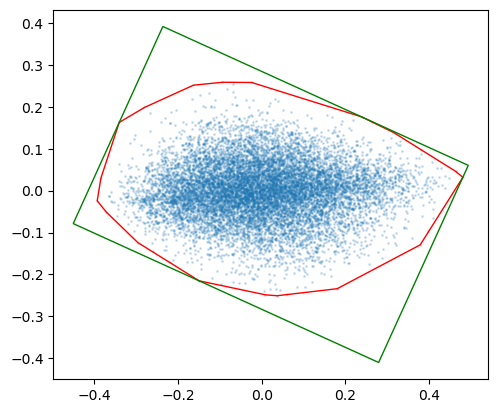

In [588]:
it.fit(X_train_norm, y=y_train, plot=True)

In [590]:
X_train_img = it.transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

In [589]:
import torchvision.transforms as transforms
from PIL import Image

In [347]:
s=np.array([[1,2,3],
   [4,5,6]],dtype=int)
f=[x*2 for x in s]
f

[array([2, 4, 6]), array([ 8, 10, 12])]

In [543]:
chosen_samples1=X_train_img[y_train_enc==0]
chosen_samples2=X_train_img[y_train_enc==1]
chosen_indices=np.random.choice(chosen_samples2.shape[0], size=29, replace=False)
transforming_samples=chosen_samples2[chosen_indices]
transforming_samples=transforming_samples.astype(np.uint8)
#chosen_samples=chosen_samples2[~chosen_indices]

transforming_samples=[Image.fromarray(image) for image in transforming_samples]

data_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transformed_samples=[data_transforms(x) for x in transforming_samples]
transformed_samples=[np.array(x) for x in transforming_samples]
new_shorts=np.concatenate((chosen_samples2,transformed_samples))
new_shorts.shape
    #y_train_modified[i+1]="short"

(79, 32, 32, 3)

In [544]:
X_train_modified=np.zeros((79*2,32,32,3))
y_train_modified=np.empty((79*2),dtype=int)
j=0
for i in range (0,79*2,2):
    X_train_modified[i]=X_train_modified[i]+chosen_samples1[j]
    X_train_modified[i+1]=X_train_modified[i+1]+new_shorts[j]
    y_train_modified[i]=0
    y_train_modified[i+1]=1
    j=j+1
    

In [361]:
np.array_equal(chosen_samples1[0],X_train_img[2])

True

## U-net Based Classifiation:

In [591]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [404]:
class CNN(torch.nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.model = torch.nn.Sequential( 
            #Input = 3 x 256 x 256, Output = 224 x 224 x 224 
            torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),  
            #torch.nn.BatchNorm2d(224),
            torch.nn.ReLU(), 
            #Input = 256 x 256 x 256, Output = 256 x 128 x 128 
            torch.nn.MaxPool2d(kernel_size=2), 
           
            

            torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1), 
            #torch.nn.BatchNorm2d(224),
            torch.nn.ReLU(), 
            # # # #Input = 512 x 16 x 16 , Output = 512 x 8 x 8  
            # #torch.nn.MaxPool2d(kernel_size=4),
            # # # # torch.nn.ReLU(), 
            torch.nn.MaxPool2d(kernel_size=2),

            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            # torch.nn.BatchNorm2d(448), 
            torch.nn.ReLU(), 
            torch.nn.MaxPool2d(kernel_size=2),

            # torch.nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1), 
            # torch.nn.ReLU(), 
            # # # #Input = 512 x 16 x 16 , Output = 512 x 8 x 8  
            # #torch.nn.MaxPool2d(kernel_size=4),
            # # # # torch.nn.ReLU(), 
            # torch.nn.MaxPool2d(kernel_size=4,stride=2),
  
            torch.nn.Flatten(), 
            torch.nn.Linear(64*4*4, 1024), 
            #torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(), 
            torch.nn.Linear(1024, 2),

           
        ) 
        self.layers=[]
  
    def forward(self, x): 
        input_shape=x.shape
        self.layers=[(0,input_shape)]

        for i,layer in enumerate(self.model):
            x=layer(x)
            output_shape=x.shape
            self.layers.append((i+1,output_shape))
        
        return x

In [377]:
model = CNN().to(device)
input_tensor=torch.randn(1,3,32,32).to(device)
output_tensor, layers_info = model(input_tensor)
for i, ((input_shape, output_shape)) in enumerate(layers_info):
    print(f"Layer {i}: Input shape = {input_shape}, Output shape = {output_shape}")

Layer 0: Input shape = 0, Output shape = torch.Size([1, 3, 32, 32])
Layer 1: Input shape = 1, Output shape = torch.Size([1, 32, 32, 32])
Layer 2: Input shape = 2, Output shape = torch.Size([1, 32, 32, 32])
Layer 3: Input shape = 3, Output shape = torch.Size([1, 32, 16, 16])
Layer 4: Input shape = 4, Output shape = torch.Size([1, 64, 16, 16])
Layer 5: Input shape = 5, Output shape = torch.Size([1, 64, 16, 16])
Layer 6: Input shape = 6, Output shape = torch.Size([1, 64, 8, 8])
Layer 7: Input shape = 7, Output shape = torch.Size([1, 64, 8, 8])
Layer 8: Input shape = 8, Output shape = torch.Size([1, 64, 8, 8])
Layer 9: Input shape = 9, Output shape = torch.Size([1, 64, 4, 4])
Layer 10: Input shape = 10, Output shape = torch.Size([1, 1024])
Layer 11: Input shape = 11, Output shape = torch.Size([1, 128])
Layer 12: Input shape = 12, Output shape = torch.Size([1, 128])
Layer 13: Input shape = 13, Output shape = torch.Size([1, 2])


In [592]:
#Selecting the appropriate training device 
model = CNN().to(device)

batch_size=5
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
])

X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
y_train_tensor = torch.from_numpy(y_train_enc).to(device)
trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
y_test_tensor = torch.from_numpy(y_test_enc).to(device)
testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)


In [593]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

# Example usage:
early_stopping = EarlyStopping(patience=10, verbose=True)


In [594]:
torch.mean(trainset[0][0][0])

tensor(0.3086, device='cuda:0')

In [595]:
#Defining the model hyper parameters 
num_epochs = 20
learning_rate = 0.0001
weight_decay = 0.01
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.1) 

#Training process begins 
train_loss_list = [] 
for epoch in range(num_epochs): 
	print(f'Epoch {epoch+1}/{num_epochs}:', end = ' ') 
	train_loss = 0
	
	#Iterating over the training dataset in batches 
	model.train() 
	for i, (images, labels) in enumerate(trainloader): 
		
		#Extracting images and target labels for the batch being iterated 
		images = images.to(device) 
		labels = labels.to(device) 

		#Calculating the model output and the cross entropy loss 
		outputs = model(images) 
		loss = criterion(outputs, labels) 

		#Updating weights according to calculated loss 
		optimizer.zero_grad() 
		loss.backward() 
		optimizer.step() 
		train_loss += loss.item()
	train_loss /= len(trainloader.dataset)
	early_stopping(train_loss, model)
	#Printing loss for each epoch 
	train_loss_list.append(train_loss/len(trainloader)) 
	

	#print(f"Training loss = {train_loss_list[-1]}") 
	if early_stopping.early_stop:
		print("Early stopping")
		break
	


Epoch 1/20: Validation loss decreased (inf --> 0.140223).  Saving model ...
Epoch 2/20: Validation loss decreased (0.140223 --> 0.140138).  Saving model ...
Epoch 3/20: Validation loss decreased (0.140138 --> 0.140052).  Saving model ...
Epoch 4/20: Validation loss decreased (0.140052 --> 0.139989).  Saving model ...
Epoch 5/20: Validation loss decreased (0.139989 --> 0.139863).  Saving model ...
Epoch 6/20: Validation loss decreased (0.139863 --> 0.139799).  Saving model ...
Epoch 7/20: Validation loss decreased (0.139799 --> 0.139719).  Saving model ...
Epoch 8/20: Validation loss decreased (0.139719 --> 0.139664).  Saving model ...
Epoch 9/20: Validation loss decreased (0.139664 --> 0.139557).  Saving model ...
Epoch 10/20: Validation loss decreased (0.139557 --> 0.139472).  Saving model ...
Epoch 11/20: Validation loss decreased (0.139472 --> 0.139352).  Saving model ...
Epoch 12/20: Validation loss decreased (0.139352 --> 0.139270).  Saving model ...
Epoch 13/20: Validation loss d

In [596]:
test_acc=0
model.eval() 
output_res=[]
output_origin=[]
exam=np.zeros((33,3,2))
p=0
  
with torch.no_grad(): 
    #Iterating over the training dataset in batches 
    for i, (images, labels) in enumerate(testloader): 
          
        images = images.to(device) 
        y_true = labels.to(device) 
        output_origin.extend(y_true.cpu().numpy())
          
        #Calculating outputs for the batch being iterated 
        outputx= model(images) 
          
        #Calculated prediction labels from models 
        _, y_pred = torch.max(outputx.data, 1) 
        output_res.extend(y_pred.cpu().numpy())

        #for debugging
        #exam[p]=exam[p]+outputx.cpu().numpy()
        p=p+1
        print(outputx)
        #Comparing predicted and true labels 
        test_acc += (y_pred == y_true).sum().item() 
      
print(f"Test set accuracy = {100 * test_acc / len(X_test_img)} %")

tensor([[0.0637, 0.0070],
        [0.0654, 0.0060],
        [0.0641, 0.0085],
        [0.0644, 0.0042],
        [0.0641, 0.0081]], device='cuda:0')
tensor([[0.0629, 0.0093],
        [0.0640, 0.0074],
        [0.0640, 0.0061],
        [0.0643, 0.0054],
        [0.0620, 0.0065]], device='cuda:0')
tensor([[0.0622, 0.0069],
        [0.0626, 0.0098],
        [0.0625, 0.0099],
        [0.0609, 0.0086],
        [0.0634, 0.0069]], device='cuda:0')
tensor([[0.0633, 0.0050],
        [0.0623, 0.0080],
        [0.0637, 0.0067],
        [0.0616, 0.0095],
        [0.0627, 0.0089]], device='cuda:0')
tensor([[0.0616, 0.0089],
        [0.0621, 0.0081],
        [0.0639, 0.0058],
        [0.0626, 0.0095],
        [0.0609, 0.0090]], device='cuda:0')
tensor([[0.0633, 0.0057],
        [0.0634, 0.0065],
        [0.0644, 0.0068],
        [0.0627, 0.0081],
        [0.0637, 0.0075]], device='cuda:0')
tensor([[0.0596, 0.0096],
        [0.0635, 0.0067]], device='cuda:0')
Test set accuracy = 68.75 %


In [ ]:
exam=np.zeros((1,3,2))
exam[0]=exam[0]+outputx.cpu().numpy()
exam[0]

<Axes: >

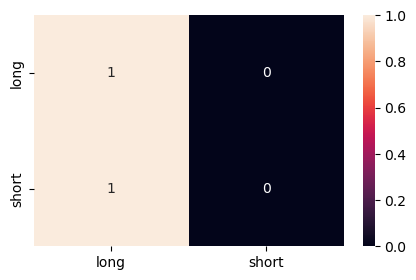

In [597]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

classes=('long','short')
cf_matrix = confusion_matrix(output_origin, output_res)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (5,3))
sn.heatmap(df_cm, annot=True)
#plt.savefig('output.png')

In [600]:
model=model.to(torch.device('cpu'))
with torch.no_grad():
    y_hat = model(X_train_tensor.cpu())
train_predicted = torch.max(y_hat, 1)[1]

print(f"The train accuracy was {accuracy_score(train_predicted, y_train_enc):.3f}")

The train accuracy was 0.695


## CNN Image Classification
Train ResNet50 CNN

In [601]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [602]:
net = timm.create_model('resnet18', pretrained=True, num_classes=num_classes).to(device)
net = net.to(device)
net.fc=nn.Linear(net.fc.in_features,2)

In [603]:
batch_size=5
preprocess = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=net.default_cfg['mean'], std=net.default_cfg['std']),
])

X_train_tensor1 = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
y_train_tensor = torch.from_numpy(y_train_enc).to(device)
trainset = TensorDataset(X_train_tensor1, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False)

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
y_test_tensor = torch.from_numpy(y_test_enc).to(device)
testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [604]:
criterion = nn.CrossEntropyLoss()
#ptimizer = optim.SGD(net.parameters(),lr=1e-02,momentum=2,)
optimizer = optim.Adam(net.parameters(),lr=0.001)

In [605]:
net.train()
net = net.to(device)
for epoch in range(50):
    for i, (inputs, labels) in enumerate(trainloader):
        clear_output(wait=True)
        display(f"Epoch {epoch:03d}, batch {i:03d}")
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

'Epoch 049, batch 025'

In [608]:
test_predicted = np.empty(0)
test_true = np.empty(0)
net=net.to(device)
net.eval()


with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
        test_predicted = np.append(test_predicted, pred)
        test_true = np.append(test_true, labels.cpu().detach().numpy())

net=net.to(torch.device('cpu'))
with torch.no_grad():
    y_hat = net(X_train_tensor1.cpu())
train_predicted = torch.max(y_hat, 1)[1]

print(f"The train accuracy was {accuracy_score(train_predicted, y_train_enc):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")


The train accuracy was 0.773
The test accuracy was 0.656


<Axes: >

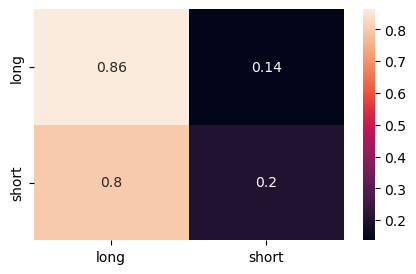

In [609]:
classes=('long','short')
cf_matrix = confusion_matrix(test_true, test_predicted)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (5,3))
sn.heatmap(df_cm, annot=True)
#plt.savefig('output.png')

## SqueezeNet

In [ ]:
import torchvision
device1 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_sq = torchvision.models.squeezenet1_1(weights='DEFAULT')
model_sq.classifier.append(nn.Flatten())
_ = model_sq.classifier.append(nn.Linear(1000, num_classes))

##transforming image to tensor
preprocess = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
X_train_tensor_sq = torch.stack([preprocess(img) for img in X_train_img]).float()
y_train_tensor_sq = torch.from_numpy(le.fit_transform(y_train))

X_test_tensor_sq = torch.stack([preprocess(img) for img in X_test_img]).float()
y_test_tensor_sq = torch.from_numpy(le.transform(y_test))

Generate pyTorch datasets and dataloaders for training and testing sets.

In [ ]:
batch_size = 10

trainset = TensorDataset(X_train_tensor_sq, y_train_tensor_sq)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = TensorDataset(X_test_tensor_sq, y_test_tensor_sq)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Specify loss function and optimization algorithm

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model_sq.parameters(),
    lr=1e-04,
    #momentum=0.8,
    weight_decay=1e-05
)

## DeepFeature: CAM-based Feature Selection

In [ ]:
model_sq.train()
model_sq.to(device1)
for epoch in range(120):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device1)
        labels = labels.to(device1)

        outputs = model_sq(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # print epoch statistics
    if not (epoch % 20):
        print(f'[{epoch}] loss: {running_loss / len(X_train_tensor_sq) * batch_size:.3f}')
print(f'[{epoch}] loss: {running_loss / len(X_train_tensor_sq) * batch_size:.3f}')

In [ ]:
model_sq.to('cpu')
model_sq = model_sq.eval()

with torch.no_grad():
    y_hat = model_sq(X_train_tensor_sq)
train_predicted = torch.max(y_hat, 1)[1]


with torch.no_grad():
    y_hat = model_sq(X_test_tensor_sq)
test_predicted = torch.max(y_hat, 1)[1]

print(f"The train accuracy was {accuracy_score(train_predicted, y_train_tensor_sq):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, y_test_tensor_sq):.3f}")

In [ ]:
cm_method='GradCAM'
camfs = CAMFeatureSelector(
    model=net,
    it=it,
    cam_method=cm_method
)

In [ ]:
fl_method = "mean"
class_cam = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method=fl_method)

In [ ]:
fs_threshold = 0.6
feat_idx = camfs.select_class_features(cams=class_cam, threshold=fs_threshold)

In [ ]:
from pytorch_grad_cam.utils.image import show_cam_on_image
from matplotlib import pyplot as plt

def cam_image(X, y, cam, fs, threshold):
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(8, 4),
                            constrained_layout=True)
    for cat in np.unique(y):
        row = cat // 4
        col = cat % 4
        cat_idx = np.where(y == cat)[0]
        X_cat = X[cat_idx,:,:,:].detach().mean(dim=0).cpu().numpy()
        cam_cat = cam[cat].copy()
        cam_cat[cam_cat <= threshold] = 0
        visualization = show_cam_on_image(
            np.transpose(X_cat, (1,2,0)),
            cam_cat,
            use_rgb=True
        )
        _ = axs[row, col].imshow(visualization)
        axs[row, col].text(0,0,le_mapping[cat],c="white",ha="left",va="top",weight="bold",size="x-large")
        axs[row, col].text(227,227,f"{fs[cat].shape[0]} genes",c="white",ha="right",va="bottom",weight="bold",size="large")
        axs[row, col].axis('off')
    return fig, axs

In [ ]:
_ = cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), class_cam, feat_idx, fs_threshold)

In [ ]:
for cat, idx in feat_idx.items():
    feature_names = genes[idx]
    print(f"{idx.shape[0]:5} features selected for {le_mapping[cat]:4}: {', '.join(feature_names[1:10])}...")